# Locality Sensitive Hashing

In [178]:
import graphlab
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [76]:
wiki = graphlab.SFrame("E:\\Machine Learning\\U.W\\Cluster and Retrieval\\people_wiki.gl/")

In [77]:
wiki = wiki.add_row_number()

In [78]:
wiki.head()

id,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...
1,<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...
2,<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...
3,<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...
4,<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...
5,<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...
6,<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...
7,<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...
8,<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...
9,<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...


## Extract TF-IDF matrix

TF-IDF document representation:

* Emphasizes **important words**: 1)Term Frequency (TF) = word counts (Appears frequently in document). For example (my own understanding), {"the": 3, "apple": 1, "matrix": 4}; 2) Inverse Doc Frequency (IDF) = log(#docs/(1+#docs using word)). For example (my own understanding), {"the": log(100/(1+80)), "apple": log(100/(1+20)), "matrix": log(100/(1+14))} 

* TF-IDF = TF * IDF


We first use GraphLab Create to compute a TF-IDF representation for each document.

In [79]:
wiki["tf_idf"] = graphlab.text_analytics.tf_idf(wiki["text"])

In [80]:
wiki.head()

id,URI,name,text,tf_idf
0,<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...,"{'since':1.455376717308041, ..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...,"{'precise':6.44320060695519, ..."
2,<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...,"{'just':2.7007299687108643, ..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...,"{'all':1.6431112434912472, ..."
4,<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...,"{'legendary':4.280856294365192, ..."
5,<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...,"{'now': 1.96695239252401,'currently': ..."
6,<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...,"{'exclusive':10.455187230695827, ..."
7,<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...,"{'taxi':6.0520214560945025, ..."
8,<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...,"{'houston':3.935505942157149, ..."
9,<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...,"{'phenomenon':5.750053426395245, ..."


* Sparse Matrix: 1) In numerical analysis and computer science, a **sparse matrix** or **sparse array** is a matrix in which most of the elements are zero. By contrast, if most of the elements are nonzero, then the matrix is considered **dense**. 2) The number of zero-valued elements divided by the total number of elements is called the **sparsity** of the matrix. 3) A matrix will be sparse when its sparsity is greater than 0.5. (https://en.wikipedia.org/wiki/Sparse_matrix)

* A good data structure for sparse matrices would only store the nonzero entries to save space and speed up computation.

* Scaled Euclidean distance: distance(x_i, x_q) = ((x_i - x_q).T * A * (x_i - x_q))^0.5 = (a_1(x_i[1] - x_q[1])^2 + ... + a_d(x_i[d] - x_q[d])^2)^0.5. For example (my own understanding): distance(Obama, Biden)(TF-IDF) = (a_1(TF-IDF(Obama["president"]) - TF-IDF(Biden["president"]))^2 + ... + a_d(TF-IDF(Obama["campaign"]) - TF-IDF(Biden["campaign"]))^2)^0.5 

We first convert the TF-IDF column (in dictionary format) into the SciPy sparse matrix format, where mat[i, j] is the value of word j for document i.

In [81]:
def sframe_to_scipy(column):
    x = graphlab.SFrame({"X1": column})
    x = x.add_row_number()
    x = x.stack("X1", ["feature", "value"])
    
    # Map words into integers using a OneHotEncoder feature transformation.
    f = graphlab.feature_engineering.OneHotEncoder(features = ["feature"])
    f.fit(x)
    x = f.transform(x)
    
    # Show the index for each feature (for example, index 0 --- bioarchaeologist, index 1 --- leaguehockey...)
    mapping = f["feature_encoding"]
    
    x["feature_id"] = x["encoded_features"].dict_keys().apply(lambda x: x[0])
    
    # Create numpy arrays that contain the data for the sparse matrix.
    i = np.array(x["id"])   # len(i)=10,379,283 >> len(wiki), since "encoded_features" are stacked for each unique ID
    j = np.array(x["feature_id"])     # len(j) = 10,379,283, len(set(j)) = 547,979 --- We have 547,979 unique features. So many duplicates 
                                      # because "feature_id" are stacked for each unique ID.
    v = np.array(x["value"])   # len(v) = 10,379,283
    width = x["id"].max() + 1   # width = wiki.rows
    height = x["feature_id"].max() + 1   # height = unique features ID
    
    # Create a sparse matrix.
    mat = csr_matrix((v, (i, j)), shape=(width, height))
    
    return mat, mapping

In [82]:
sframe_to_scipy(wiki["tf_idf"])

(<59071x547979 sparse matrix of type '<type 'numpy.float64'>'
 	with 10379283 stored elements in Compressed Sparse Row format>, Columns:
 	feature	str
 	category	str
 	index	int
 
 Rows: 547979
 
 Data:
 +---------+------------------------+-------+
 | feature |        category        | index |
 +---------+------------------------+-------+
 | feature |    bioarchaeologist    |   0   |
 | feature |      leaguehockey      |   1   |
 | feature |      electionruss      |   2   |
 | feature |        teramoto        |   3   |
 | feature | trumpeterpercussionist |   4   |
 | feature |        spoofax         |   5   |
 | feature |      mendelssohni      |   6   |
 | feature |       crosswise        |   7   |
 | feature |          yec           |   8   |
 | feature |      asianthemed       |   9   |
 +---------+------------------------+-------+
 [547979 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and colum

In [83]:
corpus, mapping = sframe_to_scipy(wiki["tf_idf"])

## Train an LSH model

LSH performs an efficient neighbor search by randomly partitioning all reference data points into different bins.

The first step is to generate a collection of random vectors from the standard Gaussian distribution.

In [84]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)   # row - dim, column - num_vector

In [85]:
np.random.seed(0)   # set seed=0 for consistent results
generate_random_vectors(num_vector = 3, dim = 5)

array([[ 1.76405235,  0.40015721,  0.97873798],
       [ 2.2408932 ,  1.86755799, -0.97727788],
       [ 0.95008842, -0.15135721, -0.10321885],
       [ 0.4105985 ,  0.14404357,  1.45427351],
       [ 0.76103773,  0.12167502,  0.44386323]])

We generate 16 vectors, leading to a 16-bit encoding of the bin index for each document.

In [86]:
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector = 16, dim = 547979)
random_vectors.shape

(547979L, 16L)

Next, we partition data points into bins.

In [87]:
doc = corpus[0, :]

In [88]:
doc

<1x547979 sparse matrix of type '<type 'numpy.float64'>'
	with 139 stored elements in Compressed Sparse Row format>

In [89]:
random_vectors[:, 0]

array([ 1.76405235,  1.49407907, -0.88778575, ...,  1.78922101,
        0.22427759, -0.08360931])

In [90]:
doc.dot(random_vectors) >= 0   # True if positive sign; False if negative sign

array([[ True,  True, False, False, False,  True,  True, False,  True,
         True,  True, False, False,  True, False,  True]])

In [91]:
np.array(doc.dot(random_vectors) >= 0, dtype = int)

array([[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1]])

All documents that obtain exactly this vector will be assigned to the same bin.

In [92]:
corpus.dot(random_vectors) >= 0

array([[ True,  True, False, ...,  True, False,  True],
       [ True, False, False, ..., False, False,  True],
       [False,  True, False, ...,  True, False,  True],
       ...,
       [ True,  True, False, ...,  True,  True,  True],
       [False,  True,  True, ...,  True, False,  True],
       [ True, False,  True, ..., False, False,  True]])

In [93]:
np.array(corpus.dot(random_vectors) >= 0, dtype = int)

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 1, 0, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 0, 1],
       [1, 0, 1, ..., 0, 0, 1]])

* We convert each binary bin index into a single integer:
```
Bin index                      integer
[0,0,0,0,0,0,0,0,0,0,0,0]   => 0
[0,0,0,0,0,0,0,0,0,0,0,1]   => 1
[0,0,0,0,0,0,0,0,0,0,1,0]   => 2
[0,0,0,0,0,0,0,0,0,0,1,1]   => 3
...
[1,1,1,1,1,1,1,1,1,1,0,0]   => 65532
[1,1,1,1,1,1,1,1,1,1,0,1]   => 65533
[1,1,1,1,1,1,1,1,1,1,1,0]   => 65534
[1,1,1,1,1,1,1,1,1,1,1,1]   => 65535 (= 2^16-1)
```

* Decimal ( https://en.wikipedia.org/wiki/Binary_number#Decimal ): 
```

To convert from a base-10 integer to its base-2 (binary) equivalent, the number is divided by two. The remainder is the least-significant bit. The quotient is again divided by two; its remainder becomes the next least significant bit. This process repeats until a quotient of one is reached. The sequence of remainders (including the final quotient of one) forms the binary value, as each remainder must be either zero or one when dividing by two.
```
```
Conversion from base-2 to base-10 simply inverts the preceding algorithm. The bits of the binary number are used one by one, starting with the most significant (leftmost) bit. Beginning with the value 0, the prior value is doubled, and the next bit is then added to produce the next value. This can be organized in a multi-column table. 


In [94]:
doc = corpus[0, :]
index_bits = np.array(doc.dot(random_vectors) >= 0, dtype = int)
powers_of_two = 1 << np.arange(15, -1, -1)

print index_bits
print powers_of_two
print index_bits.dot(powers_of_two)

[[1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50917]


In [95]:
index_bits = corpus.dot(random_vectors) >= 0
index_bits.dot(powers_of_two)

array([50917, 36265, 19365, ..., 52983, 27589, 41449])

This array gives us the integer index of the bins for all documents.

Now we are ready to complete the following function. Given the integer bin indices for the documents, you should compile a list of document IDs that belong to each bin. Since a list is to be maintained for each unique bin index, a dictionary of lists is used.

1. Compute the integer bin indices. This step is already completed.
2. For each document in the dataset, do the following:
    * Get the interger bin index for the document.
    * Fetch the list of document IDs associated with the bin. If no list exists for this bin, assign the bin an empty list.
    * Add the document ID to the end of the list.

In [96]:
def train_lsh(data, num_vector = 16, seed = None):
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
    
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    table = {}
    
    # Partition data points into bins
    bin_index_bits = data.dot(random_vectors) >= 0
    
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    #Update table so that table[i] is the list of document IDs with bin index equal to i
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            table[bin_index] = []
        table[bin_index].append(data_index)
    
    model = {"data": data,
            "bin_index_bits": bin_index_bits,
            "bin_indices": bin_indices,
            "table": table,
            "random_vectors": random_vectors,
            "num_vector": num_vector}
    
    
    return model

In [97]:
model = train_lsh(corpus, num_vector = 16, seed = 143)
table = model["table"]

## Inspect bins

Let us look at some documents and see which bins they fall into.

**Q1: What is the document ID of Barack Obama's article?**

In [98]:
wiki[wiki["name"] == "Barack Obama"]

id,URI,name,text,tf_idf
35817,<http://dbpedia.org/resource/Barack_Obama> ...,Barack Obama,barack hussein obama iibrk husen bm born august ...,"{'operations':3.811771079388818, ..."


**Q2: Which bin contains Barack Obama's article? Enter its integer index.**

In [99]:
model["bin_indices"][35817]

50194

In [100]:
wiki[wiki["name"] == "Joe Biden"]

id,URI,name,text,tf_idf
24478,<http://dbpedia.org/resource/Joe_Biden> ...,Joe Biden,joseph robinette joebiden jr dosf rbnt badn ...,"{'delaware':11.396456717061318, ..."


**Q3: Examine the bit representations of the bins containing Barack Obama and Joe Biden. In how many places do they agree?**

1. 16 out of 16 places (Barack Obama and Joe Biden fall into the same bin)
2. 14 out of 16 places
3. 12 out of 16 places
4. 10 out of 16 places
5. 8 out of 16 places

In [101]:
wiki[wiki["name"] == "Barack Obama"]   # Obama's id is 35817

id,URI,name,text,tf_idf
35817,<http://dbpedia.org/resource/Barack_Obama> ...,Barack Obama,barack hussein obama iibrk husen bm born august ...,"{'operations':3.811771079388818, ..."


In [102]:
wiki[wiki["name"] == "Joe Biden"]   # Biden's id is 24478

id,URI,name,text,tf_idf
24478,<http://dbpedia.org/resource/Joe_Biden> ...,Joe Biden,joseph robinette joebiden jr dosf rbnt badn ...,"{'delaware':11.396456717061318, ..."


In [103]:
bin_index_bits_Obama = model["bin_index_bits"][35817]

In [104]:
bin_index_bits_Biden = model["bin_index_bits"][24478]

In [105]:
sum(np.array(bin_index_bits_Obama == bin_index_bits_Biden, dtype = int))

14

Compare the result with a former British diplomat, whose bin representation agrees with Obama's in only 8 out of 16 places.

In [106]:
wiki[wiki["name"] == "Wynn Normington Hugh-Jones"]

id,URI,name,text,tf_idf
22745,<http://dbpedia.org/resource/Wynn_Normington_H ...,Wynn Normington Hugh-Jones ...,sir wynn normingtonhughjones kb sometimes ...,"{'forced':3.919175540571719, ..."


In [107]:
print np.array(model["bin_index_bits"][22745], dtype = int)
print model["bin_indices"][22745]
sum(np.array(model["bin_index_bits"][35817] == model["bin_index_bits"][22745], dtype = int))

[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]
4660


8

How about the documents in the same bin as Barack Obama? Are they necessarily more similar to Obama than Biden? Let's look at which documents are in the same bin as the Barack Obama article.

In [108]:
model["table"][model["bin_indices"][35817]]

[21426, 35817, 39426, 50261, 53937]

There are four other documents that belong to the same bin. Which documents are they?

In [109]:
doc_ids = model["table"][model["bin_indices"][35817]]

In [110]:
docs = wiki.filter_by(values = doc_ids, column_name = "id")

docs

Columns:
	id	int
	URI	str
	name	str
	text	str
	tf_idf	dict

Rows: 5

Data:
+-------+-------------------------------+-------------------------+
|   id  |              URI              |           name          |
+-------+-------------------------------+-------------------------+
| 21426 | <http://dbpedia.org/resour... |      Mark Boulware      |
| 35817 | <http://dbpedia.org/resour... |       Barack Obama      |
| 39426 | <http://dbpedia.org/resour... | John Wells (politician) |
| 50261 | <http://dbpedia.org/resour... |    Francis Longstaff    |
| 53937 | <http://dbpedia.org/resour... |  Madurai T. Srinivasan  |
+-------+-------------------------------+-------------------------+
+-------------------------------+-------------------------------+
|              text             |             tf_idf            |
+-------------------------------+-------------------------------+
| mark boulware born 1948 is... | {'ambassador': 15.90834582... |
| barack hussein obama ii br... | {'operations': 3.811771079... |
| sir john julius wells born... | {'when': 1.380605573928223... |
| francis a longstaff born a... | {'all': 1.6431112434912472... |
| maduraitsrinivasan is a we... | {'alarmelu': 21.9729907784... |
+-------------------------------+-------------------------------+
[5 rows x 5 columns]

It turns out that Joe Biden is much closer to Barack Obama than any of the four documents, even though Biden's bin representation differs from Obama's by 2 bits.

In [111]:
def norm(x):
    sum_sq = x.dot(x.T)
    norm = np.sqrt(sum_sq)
    
    return norm

In [112]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    
    return 1 - dist[0, 0]

In [113]:
obama_tf_idf = corpus[35817, :]
biden_tf_idf = corpus[24478, :]

print "================= Cosine distance from Barack Obama"
print "Barack Obama - {0:24s}: {1:f}".format("Joe Biden", cosine_distance(obama_tf_idf, biden_tf_idf))

for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id, :]
    print "Barack Obama - {0:24s}: {1:f}".format(wiki[doc_id]["name"], cosine_distance(obama_tf_idf, doc_tf_idf))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - Barack Obama            : -0.000000
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


???? Python formatting ????

**Moral of the story**. Similar data points will in general _tend to_ fall into _nearby_ bins, but that's all we can say about LSH. In a high-dimensional space such as text features, we often get unlucky with our selection of only a few random vectors such that dissimilar data points go into the same bin while similar data points fall into different bins. **Given a query document, we must consider all documents in the nearby bins and sort them according to their actual distances from the query.**

## Query the LSH model

Let's first implement the logic for searching nearby neighbors, which goes like this:

1. Let L be the bit representation of the bin that contains the query documents.
2. Consider all documents in bin L.
3. Consider documents in the bins whose bit representation differs from L by 1 bit.
4. Consider documents in the bins whose bit representation differs from L by 2 bits.
...

To obtain candidate bins that differ from the query bin by some number of bits, we use `itertools.combinations`, which produces all possible subsets of a given list. 

* itertools.combinations(iterable, r): Return r length subsequences of elements from the input iterable.
```
    1. Decide on the search radius r. This will determine the number of different bits between the two vectors.
    2. For each subset (n_1, n_2 ..., n_r) of the list [0, 1, 2, ..., num_vector-1], do the following:
        * Flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector.
        * Fetch the list of documents belonging to the bin indexed by the new bit vector.
        * Add those documents to the candidate set.

In [114]:
from itertools import combinations

In [115]:
num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius):
    print diff

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

With this output in mind, implement the logic for nearby bin search:

In [116]:
from copy import copy

In [122]:
def search_nearby_bins(query_bin_bits, table, search_radius = 2, initial_candidates = set()):
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            if query_bin_bits[i] == 0:
                alternate_bits[i] = 1
            else:
                alternate_bits[i] = 0
    
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
    
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set.
        # Make sure that the bin exists in the table.
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin])
    
    
    return candidate_set

In [123]:
obama_bin_index = model["bin_index_bits"][35817]
candidate_set = search_nearby_bins(obama_bin_index, model["table"], search_radius = 0)

In [124]:
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print 'Passed test'
else:
    print 'Check your code'
print 'List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261'

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


In [125]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print 'Passed test'
else:
    print 'Check your code'

Passed test


Now we have a function that can return all the candidates from neighboring bins. Next we write a function to collect all candidates and compute their true distance to the query.

In [160]:
from sklearn.metrics.pairwise import pairwise_distances

In [165]:
def query(vec, model, k, max_search_radius):
    data = model["data"]
    table = model["table"]
    random_vectors = model["random_vectors"]
    num_vector = random_vectors.shape[1]
    
    # Compute bin index for the query vector
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in xrange(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates = candidate_set)
    
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = graphlab.SFrame({"id": candidate_set})
    candidates = data[np.array(list(candidate_set)), :]
    nearest_neighbors["distance"] = pairwise_distances(candidates, vec, metric = "cosine").flatten()
    
    
    return nearest_neighbors.topk("distance", k, reverse = True), len(candidate_set)

In [168]:
query(corpus[35817,:], model, k=10, max_search_radius=3)

(Columns:
 	id	int
 	distance	float
 
 Rows: 10
 
 Data:
 +-------+----------------+
 |   id  |    distance    |
 +-------+----------------+
 | 35817 |      0.0       |
 | 24478 | 0.703138676734 |
 | 56008 | 0.856848127628 |
 | 37199 | 0.874668698194 |
 | 40353 | 0.890034225981 |
 |  9267 | 0.898377208819 |
 | 55909 | 0.899340396322 |
 |  9165 | 0.900921029925 |
 | 57958 | 0.903003263483 |
 | 49872 | 0.909532800353 |
 +-------+----------------+
 [10 rows x 2 columns], 727)

In [169]:
query(corpus[35817,:], model, k=10, max_search_radius=3)[0]

id,distance
35817,0.0
24478,0.703138676734
56008,0.856848127628
37199,0.874668698194
40353,0.890034225981
9267,0.898377208819
55909,0.899340396322
9165,0.900921029925
57958,0.903003263483
49872,0.909532800353


To identify the documents, it's helpful to join this table with the Wikipedia table:

In [170]:
query(corpus[35817,:], model, k=10, max_search_radius=3)[0].join(wiki[['id', 'name']], on='id').sort('distance')

id,distance,name
35817,0.0,Barack Obama
24478,0.703138676734,Joe Biden
56008,0.856848127628,Nathan Cullen
37199,0.874668698194,Barry Sullivan (lawyer)
40353,0.890034225981,Neil MacBride
9267,0.898377208819,Vikramaditya Khanna
55909,0.899340396322,Herman Cain
9165,0.900921029925,Raymond F. Clevenger
57958,0.903003263483,Michael J. Malbin
49872,0.909532800353,Lowell Barron


# Experimenting with LSH implementation

## Effect of nearby bin search

How does nearby bin search affect the outcome of LSH? There are three variables that are affected by the search radius:
* Number of candidate documents considered
* Query time
* Distance of approximate neighbors from the query

Let us run LSH multiple times, each with different radii for nearby bin search. We will measure the three variables as discussed above.

In [171]:
wiki[wiki["name"] == "Barack Obama"]

id,URI,name,text,tf_idf
35817,<http://dbpedia.org/resource/Barack_Obama> ...,Barack Obama,barack hussein obama iibrk husen bm born august ...,"{'operations':3.811771079388818, ..."


In [173]:
import time

In [176]:
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in xrange(17):
    start = time.time()
    result, num_candidates = query(corpus[35817, :], model, k = 10, max_search_radius = max_search_radius)
    end = time.time()
    query_time = end - start
    
    print "Radius:", max_search_radius
    print result.join(wiki[["id", "name"]], on = "id").sort("distance")
    
    average_distance_from_query = result["distance"][1:].mean()
    max_distance_from_query = result["distance"][1:].max()
    min_distance_from_query = result["distance"][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
+-------+----------------+-------------------------+
|   id  |    distance    |           name          |
+-------+----------------+-------------------------+
| 35817 |      0.0       |       Barack Obama      |
| 21426 | 0.950866757525 |      Mark Boulware      |
| 39426 | 0.97596600411  | John Wells (politician) |
| 50261 | 0.978256163041 |    Francis Longstaff    |
| 53937 | 0.993092148424 |  Madurai T. Srinivasan  |
+-------+----------------+-------------------------+
[5 rows x 3 columns]

Radius: 1
+-------+----------------+-------------------------------+
|   id  |    distance    |              name             |
+-------+----------------+-------------------------------+
| 35817 |      0.0       |          Barack Obama         |
| 41631 | 0.947459482005 |          Binayak Sen          |
| 21426 | 0.950866757525 |         Mark Boulware         |
| 33243 | 0.951765770113 |        Janice Lachance        |
| 33996 | 0.960859054157 |          Rufus Black          |
| 28444 |

Radius: 11
+-------+----------------+-------------------------+
|   id  |    distance    |           name          |
+-------+----------------+-------------------------+
| 35817 |      0.0       |       Barack Obama      |
| 24478 | 0.703138676734 |        Joe Biden        |
| 38376 | 0.742981902328 |      Samantha Power     |
| 57108 | 0.758358397887 |  Hillary Rodham Clinton |
| 38714 | 0.770561227601 | Eric Stern (politician) |
| 46140 | 0.784677504751 |       Robert Gibbs      |
| 44681 | 0.790926415366 |  Jesse Lee (politician) |
| 18827 | 0.798322602893 |       Henry Waxman      |
|  2412 | 0.799466360042 |     Joe the Plumber     |
| 46811 | 0.800197384104 |      Jeff Sessions      |
+-------+----------------+-------------------------+
[10 rows x 3 columns]

Radius: 12
+-------+----------------+-------------------------+
|   id  |    distance    |           name          |
+-------+----------------+-------------------------+
| 35817 |      0.0       |       Barack Obama      |
|

Let's plot the three variables:

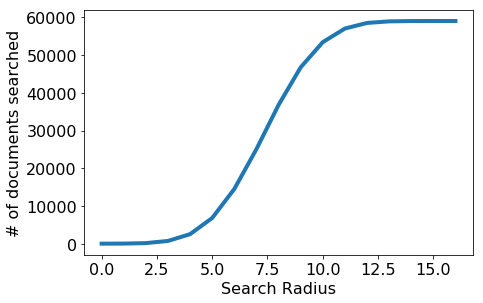

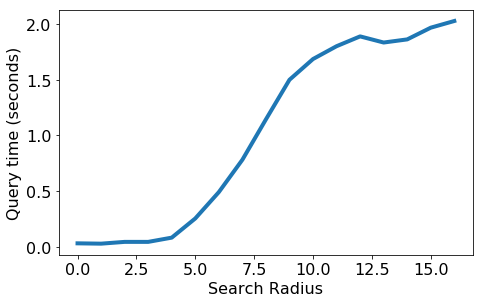

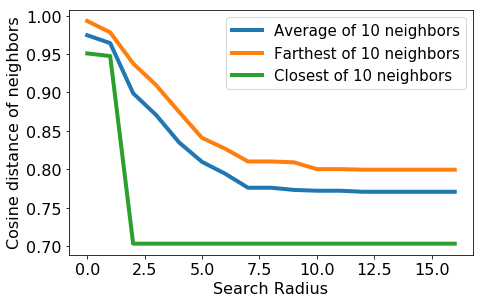

In [195]:
plt.figure(figsize = (7, 4.5))
plt.plot(num_candidates_history, linewidth = 4)
plt.xlabel("Search Radius")
plt.ylabel("# of documents searched")
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

plt.figure(figsize = (7, 4.5))
plt.plot(query_time_history, linewidth = 4)
plt.xlabel("Search Radius")
plt.ylabel("Query time (seconds)")
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

plt.figure(figsize = (7, 4.5))
plt.plot(average_distance_from_query_history, linewidth = 4, label = "Average of 10 neighbors")
plt.plot(max_distance_from_query_history, linewidth = 4, label = "Farthest of 10 neighbors")
plt.plot(min_distance_from_query_history, linewidth = 4, label = "Closest of 10 neighbors")
plt.xlabel("Search Radius")
plt.ylabel("Cosine distance of neighbors")
plt.legend(loc = "best", prop= {"size": 15})
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

Some observations:
* As we increase the search radius, we find more neighbors that are a smaller distance away.
* With increased search radius comes a greater number of documents that have to be searched, Query time is higher as a consequence.
* With sufficiently high search radius, the results of LSH begin to resemble the results of brute-force search.

**Q4: Refer to the section "Effect of nearby bin search". What was the smallest search radius that yielded the correct nearest neighbor for Obama, namely Joe Biden?**

**Q5: Suppose our goal was to produce 10 approximate nearest neighbors whose average distance from the query document is within 0.01 of the average for the true 10 nearest neighbors. For Barack Obama, the true 10 nearest neighbors are on average about 0.77. What was the smallest search radius for Barack Obama that produced an average distance of 0.78 or better?**

In [203]:
for index, distance in enumerate(average_distance_from_query_history):
    if distance <= 0.78:
        print index, distance
        break

7 0.775982605852


## Quality metrics for neighbors

The above analysis is limited by the fact that it was run with a single query, namely Barack Obama. We should repeat the analysis for the entirety of data. Iterating over all documents would take a long time, so let us randomly choose 10 documents for our analysis.

For each document, we first compute the true 25 nearest neighbors, and then run LSH multiple times. We look at two metrics:
* Precision@10: How many of the 10 neighbors given by LSH are among the true 25 nearest neighbors?
* Average cosine distance of the neighbors from the query.

Then we run LSH multiple times with different search radii.

In [204]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    nearest_neighbors = graphlab.SFrame({"id": range(num_data_points)})
    nearest_neighbors["distance"] = pairwise_distances(data, vec, metric = "cosine").flatten()
    
    return nearest_neighbors.topk("distance", k, reverse = True) 

The following cell will run LSH with multiple search radii and compute the quality metrics for each run.

In [217]:
max_radius = 17
precision = {i:[] for i in xrange(max_radius)}
average_distance = {i:[] for i in xrange(max_radius)}
query_time = {i:[] for i in xrange(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace = False)):
    print("%s / %s" % (i, num_queries))
    ground_truth = brute_force_query(corpus[ix,:], corpus, k=25)["id"]
    
    for r in xrange(1, max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix, :], model, k = 10, max_search_radius = r)
        end = time.time()
        
        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and in ground_truth)/10.0
        precision[r].append(len(set(result["id"]) and ground_truth)/10.0)
        average_distance[r].append(result["distance"][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


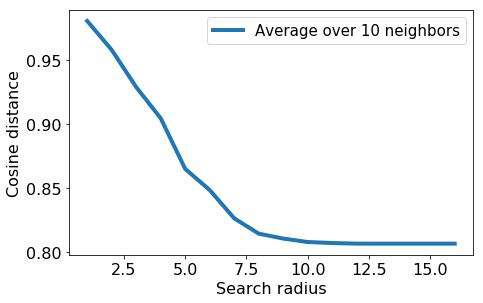

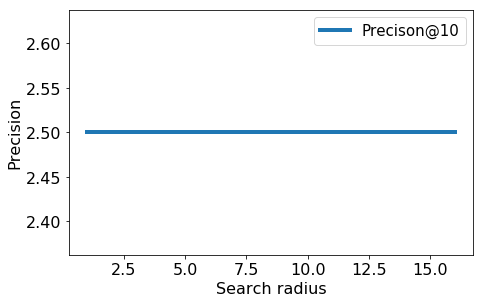

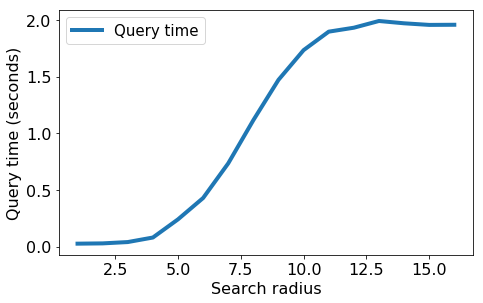

In [218]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in xrange(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in xrange(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in xrange(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Effect of number of random vectors

We run LSH with different number of random vectors, ranging from 5 to 20. We fix the search radius to 3.

In [219]:
precision = {i:[] for i in xrange(5,20)}
average_distance  = {i:[] for i in xrange(5,20)}
query_time = {i:[] for i in xrange(5,20)}
num_candidates_history = {i:[] for i in xrange(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])

    
for num_vector in xrange(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result['id']) and ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


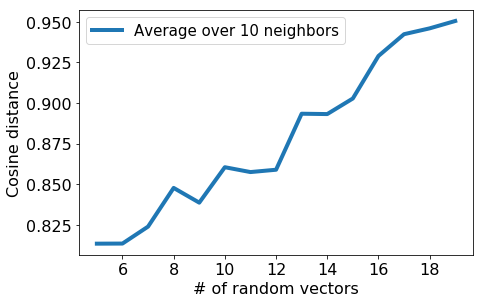

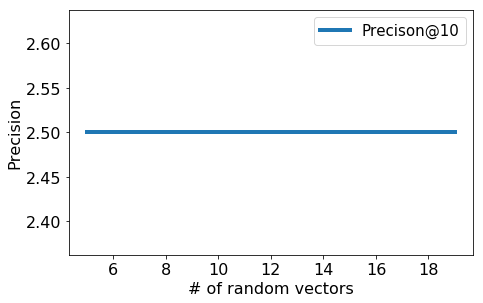

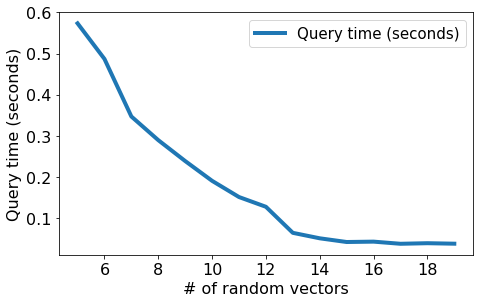

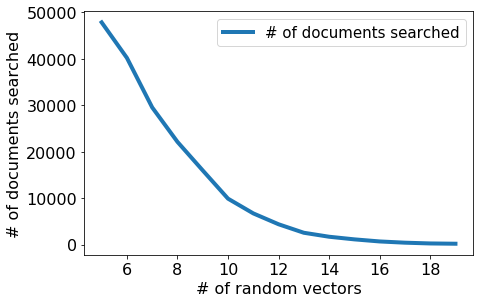

In [220]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in xrange(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in xrange(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in xrange(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in xrange(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

We see a similar trade-off between quality and performance: as the number of random vectors increases, the query time goes down as each bin contains fewer documents on average, but on average the neighbors are likewise placed farther from the query. On the other hand, when using a small enough number of random vectors, LSH becomes very similar brute-force search: Many documents appear in a single bin, so searching the query bin alone covers a lot of the corpus; then, including neighboring bins might result in searching all documents, just as in the brute-force approach.